In [ ]:
# Instalar TensorFlow si no está instalado
!pip install tensorflow

In [ ]:
# Importar las bibliotecas necesarias
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import json
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import  ParameterGrid
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Configuracion
IMG_WIDTH = 224
IMG_HEIGHT = 224
image_size = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 64
BUFFER_SIZE = tf.data.AUTOTUNE

# Paths
DATA_PATH = '/content/drive/MyDrive/TFG/Dataset/MVTec' #Data Path
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH = os.path.join(DATA_PATH, 'test')
MODEL_SAVE_PATH = os.path.join(DATA_PATH, 'models')
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Parámetros
param_grid = {
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'optimizer': ['adam', 'sgd'],
    'epochs': [10, 20, 30],
    'batch_size': [16, 32, 64 ]
}

In [ ]:
# Definir las rutas de las carpetas
viroide_dir = '/content/drive/MyDrive/sunrrise_dataset2/viroide'
sanas_dir = '/content/drive/MyDrive/sunrrise_dataset2/sanas'

# Definir el tamaño de las imágenes y la lista para almacenar las imágenes y etiquetas
img_size = (150, 150)  # Cambia el tamaño según sea necesario
images = []
labels = []



# Función para cargar imágenes
def cargar_imagenes(directorio, etiqueta):
    for img_name in os.listdir(directorio):
        img_path = os.path.join(directorio, img_name)
        img = cv2.imread(img_path)  # Leer imagen
        if img is not None: # Verificar si la imagen se cargó correctamente
            img = cv2.resize(img, img_size)  # Redimensionar imagen
            images.append(img)
            labels.append(etiqueta)
        else:
            print(f"Error al cargar la imagen: {img_path}") # Imprimir un mensaje de error si la imagen no se pudo cargar


# Cargar las imágenes de hojas enfermas (viroide) y sanas
cargar_imagenes(viroide_dir, 1)  # 1 para viroide (enfermas)
cargar_imagenes(sanas_dir, 0)  # 0 para sanas

# Convertir las listas a arrays de NumPy
images = np.array(images)
labels = np.array(labels)

# Normalizar las imágenes a rango [0, 1]
images = images / 255.0

In [ ]:
# Dividir en conjunto de entrenamiento y validación (70% entrenamiento, 30% validación)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)


In [ ]:
def create_model_1(input_shape=(150, 150, 3)):
     model = keras.Sequential(
         [
             keras.Input(shape=input_shape),
             keras.layers.Conv2D(32, kernel_size=3, activation="relu"),
             keras.layers.MaxPooling2D(pool_size=2),
             keras.layers.Conv2D(64, kernel_size=3, activation="relu"),
             keras.layers.MaxPooling2D(pool_size=2),
             keras.layers.Flatten(),
             keras.layers.Dense(1, activation="sigmoid"),  # Change to 1 neuron with sigmoid
         ]
     )

     return model


def create_model_2(input_shape=(*image_size, 3)):
    model = keras.Sequential(
        [
             layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.BatchNormalization(),  # Añadir Batch Normalization después de la capa Conv2D
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Añadir Batch Normalization
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Añadir Batch Normalization
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Añadir Batch Normalization
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')  # Clasificación binaria
        ]
    )
    return model

In [ ]:
model = create_model_1(input_shape=(150, 150, 3))
from keras.optimizers import Adam
model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Mostrar resumen del modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          82,945 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,337 (399.75 KB)

 Trainable params: 102,337 (399.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = create_model_2(input_shape=(*image_size, 3))
from keras.optimizers import Adam
model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Mostrar resumen del modelo
model.summary()

In [ ]:
# Entrenamiento y evaluación del modelo
def train_and_evaluate_model(model, train_generator, test_generator, epochs, batch_size, learning_rate=1e-3, optimizer='adam'):
    # Recompilar con los parámetros
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=test_generator,
    )
    return model, history
optimizers_to_test = ['adam', 'sgd']


#Entrenamiento inicial
best_accuracy = 0.0
best_model = None
best_model_type = None

model_types = ['model_1', 'model_2']

for model_type in model_types:
    print(f"Training {model_type}...")
    for params in ParameterGrid(param_grid):
        print(f"Training with parameters: {params}")

        # creación del modelo
        if model_type == 'model_1':
            model = create_model_1()
        elif model_type == 'model_2':
            model = create_model_2()

        # ACA! Añadir modelos adicionales!!

        from tensorflow.keras.preprocessing.image import ImageDataGenerator

        train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )
        test_datagen = ImageDataGenerator(rescale=1./255)

        # Assuming 'X_train', 'y_train', 'X_val', 'y_val' are your training and validation data
        train_generator = train_datagen.flow(
            X_train, y_train,
            batch_size=param_grid['batch_size'][0]  # Access batch_size from param_grid
        )

        test_generator = test_datagen.flow(
            X_val, y_val,
            batch_size=param_grid['batch_size'][0]  # Access batch_size from param_grid
        )

        for optimizer in optimizers_to_test:
            print(f"Training with optimizer: {optimizer}")
            # entrenamiento y evaluación
            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

            model, history = train_and_evaluate_model(
                model, train_generator, test_generator,
                epochs=params['epochs'], # Pass the integer value of epochs
                batch_size=params['batch_size'],# Pass the integer value of batch_size
                learning_rate=params['learning_rate'],
                optimizer=optimizer # Use the current optimizer
            )


        val_accuracy = history.history['val_accuracy'][-1]

        # Selección del mejor modelo
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_model_type = model_type
            best_params = param_grid

        model_filename = f"{model_type}_lr{param_grid['learning_rate']}_opt{param_grid['optimizer']}.h5"
        model_path = os.path.join(MODEL_SAVE_PATH, model_filename)
        model.save(model_path)
        print(f"Model saved to: {model_path}")

# Guardar mejor modelo
if best_model is not None:
    best_model_path = os.path.join(MODEL_SAVE_PATH, f"best_{best_model_type}_model.h5")
    best_model.save(best_model_path)
    print(f"Best model ({best_model_type}) saved to: {best_model_path} with accuracy: {best_accuracy:.4f}")

Training model_1...
Training with parameters: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'adam'}
Training with optimizer: adam
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 331ms/step - accuracy: 0.5311 - loss: 0.6953 - val_accuracy: 0.4444 - val_loss: 0.7151
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.5608 - loss: 0.6918 - val_accuracy: 0.4444 - val_loss: 0.6981
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5214 - loss: 0.6927 - val_accuracy: 0.4444 - val_loss: 0.6948
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5850 - loss: 0.6909 - val_accuracy: 0.4444 - val_loss: 0.6961
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5132 - loss: 0.6932 - val_accuracy: 0.4444 - val_loss: 0.6935
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5378 - loss: 0.6929 - val_accuracy: 0.4444 - val_loss: 0.6939
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5592 - loss: 0.6923 - val_accuracy: 0.4444 - val_loss: 0.6949
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.5150 - loss: 0.6929 - val_accuracy: 0.4444 - val_loss:

Model saved to: /content/drive/MyDrive/TFG/Dataset/MVTec/models/model_1_lr[0.001, 0.0001, 1e-05]_opt['adam', 'sgd'].h5
Training with parameters: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'optimizer': 'sgd'}
Training with optimizer: adam
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.4740 - loss: 0.6971 - val_accuracy: 0.5556 - val_loss: 0.6931
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.5355 - loss: 0.6931 - val_accuracy: 0.4444 - val_loss: 0.6934
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.5278 - loss: 0.6930 - val_accuracy: 0.4444 - val_loss: 0.6935
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5235 - loss: 0.6930 - val_accuracy: 0.4444 - val_loss: 0.6937
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5130 - loss: 0.6930 - val_accuracy: 0.4444 - val_loss: 0.6937
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.5456 - loss: 0.6927 - val_accuracy: 0.4444 - va

Model saved to: /content/drive/MyDrive/TFG/Dataset/MVTec/models/model_1_lr[0.001, 0.0001, 1e-05]_opt['adam', 'sgd'].h5
Training with parameters: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.0001, 'optimizer': 'adam'}
Training with optimizer: adam
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.5032 - loss: 0.6941 - val_accuracy: 0.4444 - val_loss: 0.6948
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.5459 - loss: 0.6921 - val_accuracy: 0.4444 - val_loss: 0.6940
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.5364 - loss: 0.6927 - val_accuracy: 0.4444 - val_loss: 0.6935
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.5218 - loss: 0.6930 - val_accuracy: 0.4444 - val_loss: 0.6953
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.5243 - loss: 0.6927 - val_accuracy: 0.4444 - val_loss: 0.6964
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5446 - loss: 0.6913 - val_accuracy: 0.4444 

Model saved to: /content/drive/MyDrive/TFG/Dataset/MVTec/models/model_1_lr[0.001, 0.0001, 1e-05]_opt['adam', 'sgd'].h5
Training with parameters: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.0001, 'optimizer': 'sgd'}
Training with optimizer: adam
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.5555 - loss: 0.6988 - val_accuracy: 0.4444 - val_loss: 0.7066
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5595 - loss: 0.6872 - val_accuracy: 0.4444 - val_loss: 0.7036
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5489 - loss: 0.6902 - val_accuracy: 0.4444 - val_loss: 0.7084
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5068 - loss: 0.6932 - val_accuracy: 0.5556 - val_loss: 0.6931
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5008 - loss: 0.6931 - val_accuracy: 0.5556 - val_loss: 0.6931
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4878 - loss: 0.6932 - val_accuracy: 0.4444 - v

In [ ]:
# cargar modelos y evaluar
best_accuracy = 0.0
best_model_path = None
best_model_type = None

saved_model_paths_keras = [f for f in os.listdir(MODEL_SAVE_PATH) if f.endswith(('.h5', '.keras'))]
saved_model_paths_tflite = [f for f in os.listdir(MODEL_SAVE_PATH) if f.endswith('.tflite')]

for model_path in saved_model_paths_keras:
    try:
        print(f"Loading Keras/H5 model: {model_path}")
        loaded_model = keras.models.load_model(os.path.join(MODEL_SAVE_PATH, model_path))

        loss, accuracy = loaded_model.evaluate(test_generator, verbose=2)
        print(f"Loaded model {model_path} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_path = model_path
            best_model_type = "keras"

    except Exception as e:
        print(f"Error loading Keras/H5 model: {e}")

for model_path in saved_model_paths_tflite:
    try:
        print(f"Loading TFLite model: {model_path}")

        interpreter = tf.lite.Interpreter(model_path=os.path.join(MODEL_SAVE_PATH, model_path))
        interpreter.allocate_tensors()

        correct_predictions = 0
        for i in range(len(test_images)):
            test_image = test_images[i]
            test_label = test_labels[i]

            interpreter.set_tensor(input_details[0]['index'], test_image)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])
            predicted_label = (output_data > 0.5).astype(int)

            if predicted_label == test_label:
                correct_predictions += 1

        accuracy = correct_predictions / len(test_images)
        print(f"Loaded model {model_path} - Test Accuracy: {accuracy:.4f}")


        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_path = model_path
            best_model_type = "tflite"

    except Exception as e:
        print(f"Error loading TFLite model: {e}")

if best_model_path:
    print(f"\nBest model: {best_model_path} (type: {best_model_type}) with accuracy {best_accuracy:.4f}")
else:
    print("No saved models found in the output directory.")


In [ ]:
# Entrenar el modelo

    # --- Parameter Grid for Exploration ---
param_grid = {
        'batch_size': [5,10],
        'epochs': [20,30],
    }

best_accuracy = 0.0
best_model_path = None

    # --- Training Loop (Choose ResNet or Sequential) ---
for model_type in ["resnet", "sequential"]:
        print(f"Training {model_type} model...")
        for params in ParameterGrid(param_grid):
            print(f"Training with parameters: {params}")
            batch_size = params['batch_size']
            epochs = params['epochs']
            history = model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val, y_val)
            )
            # Graficar precisión y pérdida
            acc = history.history['accuracy']
            val_acc = history.history['val_accuracy']
            loss = history.history['loss']
            val_loss = history.history['val_loss']

            epochs_range = range(len(acc))


            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(epochs_range, acc, label='Entrenamiento')
            plt.plot(epochs_range, val_acc, label='Validación')
            plt.legend(loc='lower right')
            plt.title('Precisión de Entrenamiento y Validación')

            plt.subplot(1, 2, 2)
            plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
            plt.plot(epochs_range, val_loss, label='Pérdida de Validación')
            plt.legend(loc='upper right')
            plt.title('Pérdida de Entrenamiento y Validación')

            plt.show()


In [ ]:
# Guardar el modelo entrenado
model.save('modelo_cnn_viroide_sanas.h5')
# Ruta a la imagen que deseas probar
image_path = '/content/2018_0101_024500_032.JPG'

# Leer la imagen y redimensionarla al tamaño esperado por el modelo (150x150 en este caso)
img_size = (150, 150)
img = cv2.imread(image_path)
if img is None:
    print(f"Error: Could not load image from {image_path}. Please check the file path and ensure the image exists.")
else:
    img = cv2.resize(img, img_size)

    # Normalizar la imagen (convertir los valores de píxel a rango [0, 1])
    img = img / 255.0

    # Expandir dimensiones para que se ajuste al formato esperado por el modelo (1, 150, 150, 3)
    img = np.expand_dims(img, axis=0)
    # Realizar la predicción
    prediction = model.predict(img)

    # Mostrar el resultado
    if prediction[0] > 0.5:
        print("La hoja está enferma (viroide).")
    else:
        print("La hoja está sana.")

In [ ]:
# Usar todo el dataset para el entrenamiento
X_train = images
y_train = labels

# Recompilar el modelo con el optimizador adam
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Entrenar el modelo con el 100% de los datos
history = model.fit(
    X_train, y_train,
    epochs=20,  # Ajusta el número de épocas según sea necesario
    batch_size=16
)
# Graficar precisión y pérdida
acc = history.history['accuracy']
loss = history.history['loss']


epochs_range = range(len(acc))

plt.figure(figsize=(12, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')

plt.show()



Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 263ms/step - accuracy: 0.9990 - loss: 0.0061
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9995 - loss: 6.2771e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.5065e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9902 - loss: 0.0196
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.6010e-05
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 2.8517e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 2.9032e-05
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.6029e-05
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 7.3830e-06
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 7.0559e-05
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.5894e-04
Epoch 12/20
25/25 ━━━━━━━

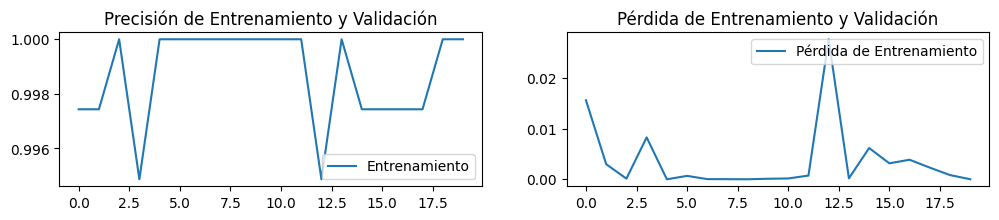

In [ ]:
# Usar todo el dataset para el entrenamiento
X_train = images
y_train = labels

# Recompilar el modelo con el optimizador sgd
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Entrenar el modelo con el 100% de los datos
history = model.fit(
    X_train, y_train,
    epochs=20,  # Ajusta el número de épocas según sea necesario
    batch_size=16
)
# Graficar precisión y pérdida
acc = history.history['accuracy']
loss = history.history['loss']


epochs_range = range(len(acc))

plt.figure(figsize=(12, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')

plt.show()



In [ ]:
# Cargar modelos entrenados para el ciclo de retroalimentación supervisada
saved_model_paths = [f for f in os.listdir(MODEL_SAVE_PATH) if f.endswith('.h5')]
optimizers_to_test = ['adam', 'sgd']


model_types = ['model_1', 'model_2']
# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale images
test_generator = test_datagen.flow_from_directory(
    viroide_dir,
    target_size=(150, 150),  # Match your model's input size
    batch_size=32,           # Adjust as needed
    class_mode='categorical',     # For binary classification ('categorical' for multi-class)
    shuffle=False             # Important for feedback loop: keep images in a predictable order
)


for model_path in saved_model_paths:
    print(f"Loading model: {model_path}")
    loaded_model = keras.models.load_model(os.path.join(MODEL_SAVE_PATH, model_path))
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )
    test_datagen = ImageDataGenerator(rescale=1./255)

        # Assuming 'X_train', 'y_train', 'X_val', 'y_val' are your training and validation data
    train_generator = train_datagen.flow(
            X_train, y_train,
            batch_size=param_grid['batch_size'][0]  # Access batch_size from param_grid
        )

    test_generator = test_datagen.flow(
            X_val, y_val,
            batch_size=param_grid['batch_size'][0]  # Access batch_size from param_grid
        )

    for optimizer in optimizers_to_test:
            print(f"Training with optimizer: {optimizer}")
            # entrenamiento y evaluación
            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


    loss, accuracy = loaded_model.evaluate(test_generator, verbose=2)
    print(f"Loaded model {model_path} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

        # Predicciones y visualización
    predictions = loaded_model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Reset the generator to get images and labels from the beginning
    test_generator.reset()
    test_images, true_labels_batch = next(test_generator)
    test_images = test_images.astype(np.uint8)  # Convert to uint8

    # Limit the number of images to display based on available labels
    num_images_to_display = min(9, len(true_labels_batch))

    plt.figure(figsize=(10, 10))
    for i in range(num_images_to_display):
                plt.subplot(3, 3, i + 1)
                plt.imshow(test_images[i])
                plt.title(f"Predicted: {predicted_classes[i]}, True: {true_labels_batch[i]}")
                plt.axis("off")
    plt.show()

            # Retroalimentación (using same batch for demonstration)
    print(f"Model: {model_path}")

            # Ensure loop iterates through the minimum of predictions, available images and available true labels
    num_feedback_images = min(len(predicted_classes), len(test_images), len(true_labels_batch))

    for i in range(num_feedback_images):
                plt.imshow(test_images[i])
                plt.title(f"Predicted: {predicted_classes[i]}, True: {true_labels_batch[i]}")
                plt.axis("off")
                plt.show()

                feedback = input(f"Image {i + 1}. Is this prediction correct (y/n)? ").lower()
    if feedback == 'n':
                    correct_class = int(input(f"Enter the correct class (0 or 1): "))
                    # TODO: reentrenar!

    print("-" * 30)

#ResNet

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, Input

# Definir la entrada
input_tensor = Input(shape=(150, 150, 3))

# Cargar el modelo ResNet50 preentrenado con los pesos de ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Congelar las capas del modelo base
base_model.trainable = False

# Añadir capas adicionales al modelo
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Global pooling en lugar de Flatten
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid')(x)  # Para una tarea de clasificación binaria

# Definir el modelo completo
model = models.Model(inputs=input_tensor, outputs=output)

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()


KeyboardInterrupt: 

#RedNormal

In [ ]:
# Definir el modelo CNN con Batch Normalization
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.BatchNormalization(),  # Añadir Batch Normalization después de la capa Conv2D
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Añadir Batch Normalization
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Añadir Batch Normalization
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Añadir Batch Normalization
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')  # Clasificación binaria
])


from keras.optimizers import Adam
model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Mostrar resumen del modelo
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 15, 15, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,454,529 (13.18 MB)

 Trainable params: 3,453,825 (13.18 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val)
)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.5303 - loss: 4.2329 - val_accuracy: 0.5556 - val_loss: 0.9482
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.7936 - loss: 0.8984 - val_accuracy: 0.5556 - val_loss: 1.8618
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.7472 - loss: 0.9202 - val_accuracy: 0.5556 - val_loss: 3.4305
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8050 - loss: 0.9365 - val_accuracy: 0.5556 - val_loss: 4.6689
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.8319 - loss: 0.5015 - val_accuracy: 0.5556 - val_loss: 3.7877
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8600 - loss: 0.4122 - val_accuracy: 0.5556 - val_loss: 3.5395
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.8489 - loss: 0.3773 - val_accuracy: 0.5556 - val_loss: 3.2954
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.8683 - loss: 0.2867 - val_accuracy: 0.5556 - val_loss: 3.0809
Epoch 9/

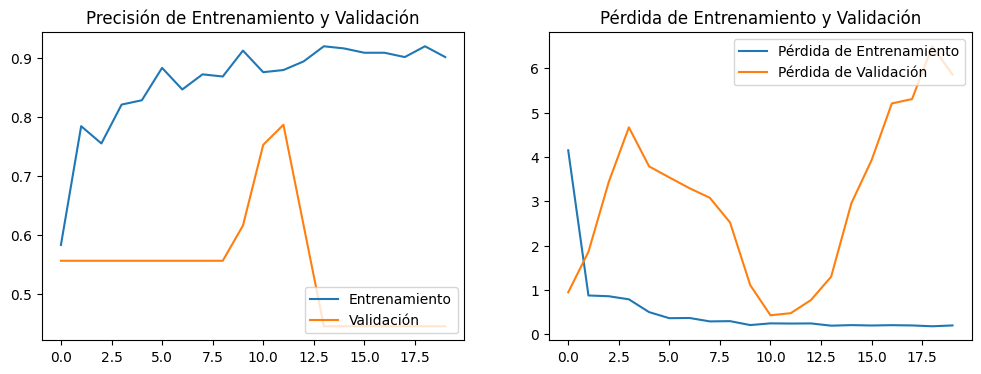

In [ ]:
# Graficar precisión y pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de Validación')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')

plt.show()


In [ ]:
# Guardar el modelo entrenado
model.save('modelo_cnn_viroide_sanas.h5')


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# Cargar el modelo previamente entrenado
model = load_model('modelo_cnn_viroide_sanas.h5')

In [ ]:
# Cargar el modelo previamente entrenado
model = load_model('modelo_cnn_viroide_sanas.h5')

In [ ]:
# Ruta a la imagen que deseas probar
image_path = '/content/2018_0101_024500_032.JPG'

# Leer la imagen y redimensionarla al tamaño esperado por el modelo (150x150 en este caso)
img_size = (150, 150)
img = cv2.imread(image_path)
img = cv2.resize(img, img_size)

# Normalizar la imagen (convertir los valores de píxel a rango [0, 1])
img = img / 255.0

# Expandir dimensiones para que se ajuste al formato esperado por el modelo (1, 150, 150, 3)
img = np.expand_dims(img, axis=0)


In [ ]:
# Realizar la predicción
prediction = model.predict(img)

# Mostrar el resultado
if prediction[0] > 0.5:
    print("La hoja está enferma (viroide).")
else:
    print("La hoja está sana.")


In [ ]:
# Ya es necesario dividir los datos
# X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

# Usar todo el dataset para el entrenamiento
X_train = images
y_train = labels


In [ ]:

# Recompilar el modelo para evitar el error con el optimizador
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Entrenar el modelo con el 100% de los datos
history = model.fit(
    X_train, y_train,
    epochs=20,  # Ajusta el número de épocas según sea necesario
    batch_size=16
)


In [ ]:
# Graficar precisión y pérdida
acc = history.history['accuracy']
loss = history.history['loss']


epochs_range = range(50)

plt.figure(figsize=(12, 2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')

plt.show()
